# How to implement a Variational Autoencoder (VAE)

A variational autoencoder observes data, infers a latent code for it and tries to reconstruct the data from that latent code. In contrast to regular autoencoders, the code of the VAE is **random**. That means that when presented with the same input, the VAE will produce a slightly different code each time. This makes its decoding process more robust, since it has to deal with noisy code.

Another way of looking at a VAE is as a training procedure for a probablistic model. The model is 
$$p(x) = \int p(z)p(x|z) dz$$
where $z$ is the latent code and $x$ is the data. During training we need to infer a posterior over $z$. In the case of a VAE this is done by neural network.

Assuming that the theory of VAEs has already been presented, we now dive straight into implementing them. If you need more background on VAEs, have a look at our [tutorial slides](https://github.com/philschulz/VITutorial/tree/master/modules) and the references therein.

# The Framework

For the purpose of this tutorial we are going to use [mxnet](https://mxnet.incubator.apache.org) which is a scalable deep learning library that has interfaces for several languages, including Python. We are going to import and abbreviate it as "mx". We will use mxnet to define a computation graph. This is done using the [symbol library](https://mxnet.incubator.apache.org/api/python/symbol.html). When building the VAE, all the methods that you use should be prefixed with `mx.sym`.

In [1]:
import mxnet as mx
import numpy as np
import urllib.request
import os, logging, sys
from os.path import join, exists
from abc import ABC
from typing import List, Tuple, Callable, Optional, Iterable
from matplotlib import cm, pyplot as plt
from math import sqrt

Next, we specify a couple of constants that will help us to load the data.

In [2]:
DEFAULT_LEARNING_RATE = 0.0003

TRAIN_SET = 'train'
VALID_SET = 'valid'
TEST_SET = 'test'
data_names = [TRAIN_SET, VALID_SET, TEST_SET]
test_set = [TEST_SET]
data_dir = join(os.curdir, "binary_mnist")

# change this to mx.gpu(0) if you want to run your code on gpu
ctx = mx.cpu()

Finally, we set up basic logging facilities to print intermediate output.

In [3]:
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s [%(levelname)s]: %(message)s", datefmt="%H:%M:%S")

# The Data

Throughout the tutorial we will use the binarised MNIST data set consisting of images of handwritten digits (0-9). 
The binarisation was done by sampling each pixel from a Bernoulli distribution with the pixel's original intensity being the Bernoulli parameter (see [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.141.1680&rep=rep1&type=pdf) for details).Each pixel has been mapped to either 0 or 1, meaning that pixels are either fully on or off. We use this data set because it allows us to use a rather simple product of Bernoullis as a likelihood. We download the data into a folder called "binary_mnist". This may take some time.

In [4]:
if not exists(data_dir):
    os.mkdir(data_dir)
for data_set in data_names:
    file_name = "binary_mnist.{}".format(data_set)
    goal = join(data_dir, file_name)
    if exists(goal):
        logging.info("Data file {} exists".format(file_name))
    else:
        logging.info("Downloading {}".format(file_name))
        link = "http://www.cs.toronto.edu/~larocheh/public/datasets/binarized_mnist/binarized_mnist_{}.amat".format(
            data_set)
        urllib.request.urlretrieve(link, goal)
        logging.info("Finished")

11:08:56 [INFO]: Data file binary_mnist.train exists
11:08:56 [INFO]: Data file binary_mnist.valid exists
11:08:56 [INFO]: Data file binary_mnist.test exists


Alright, now we have the data on disk. We will load the training and test data later. Right now we just load the validation set to see what the data looks like. We'll grab 5 random numbers and visualise them (you can run this box several times to get 5 different digits each time). That the digits look a bit rough results from their pixels being binarised.

In [5]:
file_name = join(data_dir, "binary_mnist.{}".format(VALID_SET))
logging.info("Reading {} into memory".format(file_name))
valid_set = np.genfromtxt(file_name)

11:09:11 [INFO]: Reading ./binary_mnist/binary_mnist.valid into memory


11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/ivna/venv/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:32 [DEBUG]: update_title_pos
11:09:33 [DEBUG]: update_title_pos
11:09:33 [DEBUG]: update_title_pos
11:09:33 [DEBUG]: update_title_pos
11:09:33 [DEBUG]: update_title_pos
11:09:33 [DEBUG]: update_title_pos
11:09:33 [DEBUG]: update_title_pos


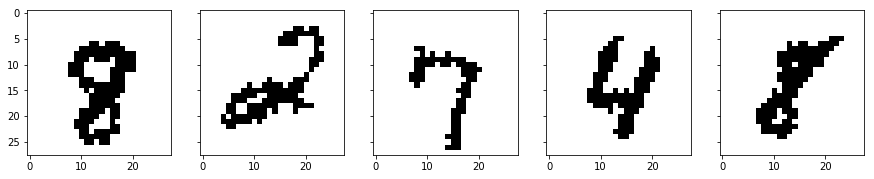

In [6]:
random_indeces = np.random.randint(valid_set.shape[0], size=5)
random_pictures = valid_set[random_indeces, :]
width = height = int(sqrt(random_pictures.shape[1]))
plot, axes = plt.subplots(1,5,  sharex='col', sharey='row', figsize=(15,3))
for i in range(5):
    axes[i].imshow(np.reshape(random_pictures[i,:],(width,height)), cmap=cm.Greys)
plt.show()

After having acquainted ourselves with the data we can now proceed to build our VAE.

# Diagonal Gaussian VAE

The most basic VAE model is one where we assume that the latent variable is multiviariate Gaussian. We fix the prior to be standard normal. During inference, we use a multivariate Gaussian variational distribution with diagonal covariance matrix. This means that we are only modelling variance but not covariance (in fact, a k-dimensional Guassian with diagonal covariance has the same density as a product of k independent univariate Gaussians). Geometrically, this variational distribution can only account for axis-aligned elliptical densities. It is thus rather limited in its modelling capabilities. Still, because it uses a neural network under the hood, it is very expressive. 

In this tutorial, we will model the mist binarised digit data set. Each image is encoded as a 784-dimensional vector. We will model each of these vectors as a product of 784 Bernoullis (of course, there are better models but we want to keep it simple). Our likelihood is thus a product of independent Bernoullis. The resulting model is formally specified as 

\begin{align}z \sim \mathcal{N}(0,I) && x_i|z \sim Bernoulli(NN_{\theta}(z))~~~ i \in \{1,2,\ldots, 784\} \ .\end{align}

The variational approximation is given by $$q(z|x) = \mathcal{N}(NN_{\lambda}(x), NN_{\lambda}(x)).$$

Notice that both the Bernoulli likelihood and the Gaussian variational distribution use NNs to compute their parameters. The parameters of the NNs, however, are different ($\theta$ and $\lambda$, respectively).

## Implementation

We will spread our implementation across 3 classes. This design choice is motivated by the desire to make our models as modular as possible. This will later allow us to mix and match different likelihoods and variational distributions.

* **Generator**: This class defines our likelihood. Given a latent value, it produces a data sample or assigns a density to an existing data point.
* **InferenceNetwork**: This neural network computes the parameters of the variational approximation from a data point.
* **VAE**: This is the variational autoencoder. It combines a Generator and an InferenceNetwork and trains them jointly. Once trained, it can generate random data points or try to reproduce data presented to it.

Below we have specified these classes abstractly. Make sure you understand what each method is supposed to be doing.

In [69]:
class Generator(ABC):
    """
    Generator network.

    :param data_dims: Dimensionality of the generated data.
    :param layer_sizes: Size of each hidden layer in the network.
    :param act_type: The activation after each hidden layer.
    """

    def __init__(self, data_dims: int, layer_sizes: List[int], act_type: str) -> None:
        self.data_dims = data_dims
        self.layer_sizes = layer_sizes
        self.act_type = act_type

    def generate_sample(self, latent_state: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Generate a data sample from a latent state.

        :param latent_state: The latent input state.
        :return: A data sample.
        """
        raise NotImplementedError()

    def train(self, latent_state: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator from a given latent state.
        
        :param latent_state: The latent input state.
        :return: The loss symbol used for training.
        """
        raise NotImplementedError()

        
class InferenceNetwork(ABC):
    """
    A network to infer distributions over latent states.

    :param latent_variable_size: The dimensionality of the latent variable.
    :param layer_sizes: Size of each hidden layer in the network.
    :param act_type: The activation after each hidden layer.
    """

    def __init__(self, latent_variable_size: int, layer_sizes: List[int], act_type: str) -> None:
        self.latent_var_size = latent_variable_size
        self.layer_sizes = layer_sizes
        self.act_type = act_type

    def inference(self, data: mx.sym.Symbol) -> Tuple[mx.sym.Symbol, ...]:
        """
        Infer the parameters of the distribution over latent values.

        :param data: A data sample.
        :return: The parameters of the distribution.
        """
        raise NotImplementedError()
        
    def get_kl_loss(params_q: Iterable[mx.sym.Symbol], params_p: Iterable[mx.sym.Symbol]) -> mx.sym.Symbol:
        """
        Create a loss symbol for the kl term associated with the inference net.
        
        :param params_q: The parameters of the variational distribution.
        :param params_p: The parameters of the model prior.
        """
        raise NotImplementedError()
        
        
class VAE(ABC):
    """
    A variational autoencoding model (Kingma and Welling, 2014).

    :param generator: A generator network that specifies the likelihood of the model.
    :param inference_net: An inference network that specifies the distribution over latent values.
    """

    def __init__(self, generator: Generator, inference_net: InferenceNetwork) -> None:
        self.generator = generator
        self.inference_net = inference_net

    def train(self, data: mx.sym.Symbol, label: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator and inference network jointly by optimising the ELBO.

        :param data: The training data.
        :param label: Copy of the training data.
        :return: A grouped list of loss symbols.
        """
        raise NotImplementedError()

    def generate_reconstructions(self, data: mx.sym.Symbol, n: int) -> mx.sym.Symbol:
        """
        Generate a number of reconstructions of input data points.

        :param data: The input data.
        :param n: Number of reconstructions per data point.
        :return: The reconstructed data.
        """
        raise NotImplementedError()

    def phantasize(self, n: int) -> mx.sym.Symbol:
        """
        Generate data by randomly sampling from the prior.

        :param n: Number of sampled data points.
        :return: Randomly generated data points.
        """
        raise NotImplementedError()

## Exercise 1
Let us start by implementing the generator. This is pretty much a standard neural network. The main point of this exercise is to get you comfortable with mxnet. Complete all the TODOs below. Before starting, check mxnet's [fully connected layer](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.FullyConnected) and [activation functions](https://mxnet.incubator.apache.org/api/python/symbol.html#mxnet.symbol.Activation).

In [108]:
class ProductOfBernoullisGenerator(Generator):
    """
    A generator that produces binary vectors whose entries are independent Bernoulli draws.

    :param data_dims: Dimensionality of the generated data.
    :param layer_sizes: Size of each hidden layer in the network.
    :param act_type: The activation after each hidden layer.
    """

    def __init__(self, data_dims: int, layer_sizes=List[int], act_type=str) -> None:
        super().__init__(data_dims, layer_sizes, act_type)
        # TODO choose the correct output activation for a Bernoulli variable. This should just be a string.
        self.output_act = 'sigmoid' # or softmax?

    def _preactivation(self, latent_state: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Computes the pre-activation of the generator, i.e. the hidden state before the final output activation.

        :param latent_state: The input latent state.
        :return: The pre-activation before output activation.
        """
        prev_out = latent_state
        for i, size in enumerate(self.layer_sizes):
            # TODO for each layer size in layer_sizes, introduce a layer that performs an affine transformation 
            # (implemented by mx.sym.FullyConnected) followed by a non-linearity that is specified by self.act_type.
            # Call the resulting symbol act_i and uncomment the line below
            
            fc_i  = mx.sym.FullyConnected(prev_out, num_hidden=size, name='gen_FC%d' % i)
            act_i = mx.sym.Activation(data=fc_i, act_type=self.act_type, name='gen_Act%d' % i)
            prev_out = act_i
 

        # The output layer that gives pre_activations for multiple Bernoulli softmax between 0 and 1
        fc_out = mx.sym.FullyConnected(data=prev_out, num_hidden=self.data_dims, name="gen_fc_out")

        return fc_out
    
    def generate_sample(self, latent_state: mx.sym.Symbol, binarise: bool = False) -> Tuple[mx.sym.Symbol, mx.sym.Symbol]:
        """
        Generates a data sample. The stochasticity in the sampling
        process comes from the latent_state. Either returns the Bernoulli parameters or the maximally likely
        outcome.

        :param latent_state: The input latent state.
        :param binarise: Return discrete values instead of Bernoulli parameters.
        :return: A vector of Bernoulli draws and the latent state from which they were generated.
        """
        act = mx.sym.Activation(data=self._preactivation(latent_state=latent_state), act_type=self.output_act,
                                name="gen_act_out")
        out = act > 0.5 if binarise else act
        return out, latent_state
    
    def train(self, latent_state=mx.sym.Symbol, label=mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator from a given latent state.

        :param latent_state: The input latent state.
        :param label: A binary vector (same as input for inference module).
        :return: The loss symbol used for training.
        """
        output = mx.sym.Activation(data=self._preactivation(latent_state=latent_state), act_type=self.output_act,
                                   name="output_act")
        return mx.sym.MakeLoss(-mx.sym.sum(label * mx.sym.log(output) + (1-label) * mx.sym.log(1-output), axis=1))

We now move on to the inference network. Recall that this network will return the parameters of a diagonal Gaussian. Thus, we need to return two vectors of the same size: a mean and a standard deviation vector. (Formally, the parameters of the Gaussian are the variances. However, from the derivation of the Gaussian reparametrisation we know that we
need the standard deviations to generate a Gaussian random variable $z$ as transformation of a standard Gaussian variable $\epsilon$.)








## Exercise 2.a
To train our VAE we need to compute the KL of the prior distribution from the variational approximation. Assuming that
the prior is standard normal the KL for the a diagonal Gaussian variational approximation is
$$ 0.5 * \left(\sum_i - \log(\sigma_i^2) - 1 + \sigma_i^2 + \mu_i^2 \right) \ . $$
We use this KL divergence in the get_kl_loss method below of the GaussianInferenceNetwork. (Losses in mxnet are defined using the [MakeLoss](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.MakeLoss) symbol.) Please implement the function diagonal_gaussian_kl. Use the [sum](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.sum) and [log](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.log) symbols in the process.

In [109]:
def diagonal_gaussian_kl(mean: mx.sym.Symbol, std: mx.sym.Symbol) -> mx.sym.Symbol:
    """
    Computes the KL divergence of a standard normal distribution from a diagonal Gaussian.
    
    :param mean: The mean of the diagonal Gaussian.
    :param std: The standard deviations of the diagonal Gaussian.
    :return: The value of the Kl divergence.
    """
    # TODO: implement the diagonal gaussian Kl divergence
    
    kl_divergence = 0.5 * mx.sym.sum(-mx.sym.log(std**2)-1 + std**2 + mean**2, axis=1)
    return kl_divergence

## Exercise 2.b
We can finally implement the Gaussian reparametrisation. Fill in the correct code to perform the sampling in the sample_latent_state method.

**Hint:** In this exercise you will need to draw a random Gaussian sample (see [here](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.random_normal)). The operator requires a
shape whose first entry is the batch size. The batch size is not known to you during implementation, however.
You can leave it underspecified by choosing $0$ as a value. When you combine the sampling operator with another
operator mxnet will infer the correct the batch size for you.

In [110]:
class GaussianInferenceNetwork(InferenceNetwork):
    """
    An inference network that predicts the parameters of a diagonal Gaussian and samples from that distribution.

    :param latent_variable_size: The dimensionality of the latent variable.
    :param layer_sizes: Size of each hidden layer in the network.
    :param act_type: The activation after each hidden layer.
    """

    def __init__(self, latent_variable_size: int, layer_sizes: List[int], act_type: str):
        super().__init__(latent_variable_size, layer_sizes, act_type)

    def inference(self, data: mx.sym.Symbol) -> Tuple[mx.sym.Symbol, mx.sym.Symbol]:
        """
        Infer the mean and standard deviation.

        :param data: A data sample.
        :return: The mean and standard deviation.
        """
        # We choose to share the first layer between the networks that compute the standard deviations
        # and means. This is a fairly standard design choice.
        shared_layer = mx.sym.FullyConnected(data=data, num_hidden=self.layer_sizes[0], name="inf_joint_fc")
        shared_layer = mx.sym.Activation(data=shared_layer, act_type=self.act_type, name="inf_joint_act")

        prev_out = shared_layer
        for i, size in enumerate(self.layer_sizes[1:]):
            # TODO: do what you did for the generator in exercise 1.
            mean_fc_i = mx.sym.FullyConnected(data=prev_out, num_hidden=size, name="FC_m_%d" % i)
            mean_act_i = mx.sym.Activation(data=mean_fc_i, act_type=self.act_type, name="Act_m_%d" %i)
            prev_out = mean_act_i
        mean = mx.sym.FullyConnected(data=prev_out, num_hidden=self.latent_var_size, name="inf_mean_compute")

        prev_out = shared_layer
        for i, size in enumerate(self.layer_sizes[1:]):
            # TODO: again, same exercise.
            var_fc_i = mx.sym.FullyConnected(data=prev_out, num_hidden=size, name="FC_v_%d" % i)
            var_act_i = mx.sym.Activation(data=var_fc_i, act_type=self.act_type, name="Act_v_%d" %i)
            prev_out = var_act_i
        # TODO: The standard deviation is constrained to be positive for non-degenerate Gaussians. Take the
        # prev_out symbol and transform it into a vector of positive reals.
        std = mx.sym.Activation(mx.sym.FullyConnected(data=prev_out, num_hidden=self.latent_var_size, name="var_compute"),
                                act_type='softrelu', name='softrelu_')

        return mean, std
    
    def get_kl_loss(self, mean: mx.sym.Symbol, std: mx.sym.Symbol) -> mx.sym.Symbol:
        return mx.sym.MakeLoss(diagonal_gaussian_kl(mean, std), name="gaussian_kl_loss")

    def sample_latent_state(self, mean: mx.sym.Symbol, std: mx.sym.Symbol, n: Optional[int] = 1) -> mx.sym.Symbol:
        """
        Sample a value for the latent Gaussian variable.

        :param mean: The mean of the Gaussian.
        :param std: The standard deviation of the Gaussian.
        :param n: Number of samples to be produced.
        :return: A Gaussian sample.
        """
        if n > 1:
            # TODO: make sure this can be used during training
            mean = mx.sym.tile(data=mean, reps=(n,1), name="inf_net_replicate_mean")
            std = mx.sym.tile(data=std, reps=(n,1), name="inf_net_replicate_std")
        # TODO: This is where the magic happens! Draw a sample from the Gaussian using the Gaussian reparametrisation
        # trick and return it.
        return mean + std * mx.sym.random_normal(loc=0, scale=1, shape=(0, self.latent_var_size))


# Exercise 3

The only thing that is left to do is to implement VAE training. To train our VAE we will maximise the ELBO:
$$ \mathbb{E}\left[ \log p(x|z) \right] - \text{KL}(q(z|x)||p(z)) \ . $$
By default, MXNet's optimisers minimise losses instead of maximising objectives. We thus turn the ELBO into a loss by taking its negative. We already get the (sampled) cross entropy loss and (analytically computed) KL divergence as return values form calls to the Generator and inference network respectively. Your job is to combine them into one loss. In mxnet this can be done using the [Group symbol](https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Group). If a list of losses is provided as an argument to this symbol, the optimiser will add up these losses.

**Note**: We could just as well have added up the values of the cross-entropy and the KL divergence and put the resulting loss into a MakeLoss symbol. The reason why we want to separate these two terms of the loss is that it allows us to output KL divergence. We will use this below when defining the KLMetric. Besides tracking the ELBO, which is our optimisation objective, we can also track to KL divergence to see how far the variational approximation moves away from the prior.

In [111]:
class GaussianVAE(VAE):
    """
    A VAE with Gaussian latent variables. It assumes a standard normal prior on the latent values.

    :param generator: A generator network that specifies the likelihood of the model.
    :param inference_net: An inference network that specifies the Gaussian over latent values.
    """

    def __init__(self,
                 generator: Generator,
                 inference_net: GaussianInferenceNetwork,
                 kl_divergence: Callable) -> None:
        self.generator = generator
        self.inference_net = inference_net
        self.kl_divergence = kl_divergence

    def train(self, data: mx.sym.Symbol, label: mx.sym.Symbol) -> mx.sym.Symbol:
        """
        Train the generator and inference network jointly by optimising the ELBO.

        :param data: The training data.
        :param label: Copy of the training data.
        :return: A list of loss symbols.
        """
        # TODO implement the train method. Make sure to include all relevant loss terms.
        mean, std = self.inference_net.inference(data)
        latent_state = self.inference_net.sample_latent_state(mean, std)
        kl_loss = self.inference_net.get_kl_loss(mean, std)
        
        cross_entropy = self.generator.train(latent_state, label)
        
        loss = mx.sym.Group([-cross_entropy, kl_loss])
        return loss
        #return mx.sym.MakeLoss(kl_loss - cross_entropy, name="negative_ELBO")

    def generate_reconstructions(self, data: mx.sym.Symbol, n: int) -> mx.sym.Symbol:
        """
        Generate a number of reconstructions of input data points.

        :param data: The input data.
        :param n: Number of reconstructions per data point.
        :return: The reconstructed data.
        """
        mean, std = self.inference_net.inference(data=data)
        mean = mx.sym.tile(data=mean, reps=(n, 1))
        std = mx.sym.tile(data=std, reps=(n, 1))
        latent_state = self.inference_net.sample_latent_state(mean, std, n)
        return self.generator.generate_sample(latent_state=latent_state)

    def phantasize(self, n: int) -> mx.sym.Symbol:
        """
        Generate data by randomly sampling from the prior.

        :param n: Number of sampled data points.
        :return: Randomly generated data points.
        """
        latent_state = mx.sym.random_normal(loc=0, scale=1, shape=(n, self.inference_net.latent_var_size))
        return self.generator.generate_sample(latent_state=latent_state)

# Constructing a VAE

We have now all the code for VAEs in place. Below, we have defined a factory method that makes it easier for you to play with different architectures.

In [123]:
def construct_vae(latent_type: str,
                  likelihood: str,
                  generator_layer_sizes: List[int],
                  infer_layer_sizes: List[int],
                  latent_variable_size: int,
                  data_dims: int,
                  generator_act_type: str = "tanh",
                  infer_act_type: str = "tanh") -> VAE:
    """
    Construct a variational autoencoder

    :param latent_type: Distribution of latent variable.
    :param likelihood: Type of likelihood.
    :param generator_layer_sizes: Sizes of generator hidden layers.
    :param infer_layer_size: Sizes of inference network hidden layers.
    :param latent_variable_size: Size of the latent variable.
    :param data_dims: Dimensionality of the data.
    :param generator_act_type: Activation function for generator hidden layers.
    :param infer_act_type: Activation function for inference network hidden layers.
    :return: A variational autoencoder.
    """
    if likelihood == "bernoulliProd":
        generator = ProductOfBernoullisGenerator(data_dims=data_dims, layer_sizes=generator_layer_sizes,
                                                 act_type=generator_act_type)
    else:
        raise Exception("{} is an invalid likelihood type.".format(likelihood))

    if latent_type == "gaussian":
        inference_net = GaussianInferenceNetwork(latent_variable_size=latent_variable_size,
                                                 layer_sizes=infer_layer_sizes,
                                                 act_type=infer_act_type)
    else:
        raise Exception("{} is an invalid latent variable type.".format(latent_type))
        
    return GaussianVAE(generator=generator, inference_net=inference_net, kl_divergence=diagonal_gaussian_kl)

# Exercise 4

Your turn! Construct your own VAE below.

In [124]:
vae = construct_vae(latent_type="gaussian", likelihood="bernoulliProd", generator_layer_sizes=[200,500],
                   infer_layer_sizes=[500,200], latent_variable_size=200, data_dims=784, generator_act_type="tanh",
                   infer_act_type="tanh")

To check what your VAE looks like we will visualise it. The variables are "data" and "label" are unbound variables in the computation graph. We will shortly use them to supply data to the model.

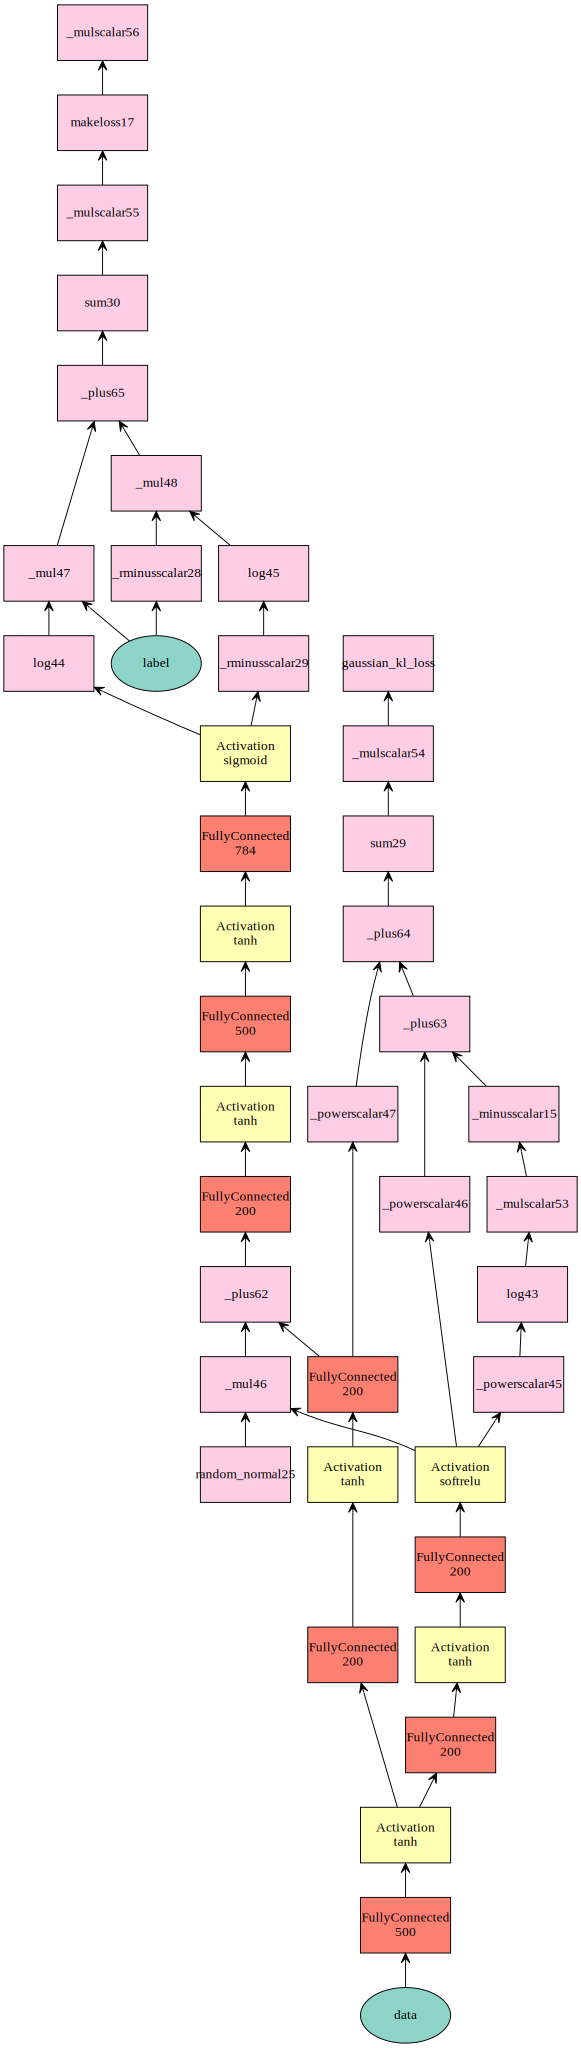

In [125]:
data = mx.sym.Variable("data")
label = mx.sym.Variable("label")
mx.viz.plot_network(vae.train(data, label))
# Comment out the line above and uncomment the one below if you want to save the VAE picture on disk
#mx.viz.plot_network(vae.train(data, label), title="my_vae", save_format="pdf")

# Training a VAE

We are now set to train the VAE. In order to do so we have to define a data iterator and a module in mxnet. The data iterator takes care of batching the data while the module executes the computation graph and updates the model parameters. For the purpose of training the model, we only need the training data which we load from disk.

In [59]:
mnist = {}
file_name = join(data_dir, "binary_mnist.{}".format(TRAIN_SET))
logging.info("Reading {} into memory".format(file_name))
mnist[TRAIN_SET] = mx.nd.array(np.genfromtxt(file_name))
logging.info("{} contains {} data points".format(file_name, mnist[TRAIN_SET].shape[0]))

15:00:08 [INFO]: Reading ./binary_mnist/binary_mnist.train into memory
15:01:26 [INFO]: ./binary_mnist/binary_mnist.train contains 50000 data points


Using that data we define the training set iterator. At this point we also need to choose a batch_size that will then be used in training. Notice that we randomise the order in which the data points are presented in the training set. It is important that `data_name` and `label_name` match the names of the unbound variables in our model. MXNet will use this information to pass the correct data points to the variables. Finally, notice that the data and labels are identical. This is because the VAE tries to reconstruct its input data and thus labels and data are the same.

In [126]:
batch_size = 200
train_iter = mx.io.NDArrayIter(data=mnist[TRAIN_SET], data_name="data", label=mnist[TRAIN_SET], label_name="label",
                                   batch_size=batch_size, shuffle=True)

Now we can define a module that will do the training for us.

In [127]:
vae_module = mx.module.Module(vae.train(data=mx.sym.Variable("data"), label=mx.sym.Variable("label")),
                           data_names=[train_iter.provide_data[0][0]],
                           label_names=[train_iter.provide_label[0][0]], context=ctx, logger=logging)

Training the vae (or any other network defined in mxnet) is most easily done using the [fit method](https://mxnet.incubator.apache.org/api/python/module/module.html#mxnet.module.BaseModule.fit). Here we choose to train our model for 20 epochs. Our optimiser will be adam. Training will take some time (approximately 2-5 minutes, depending on your machine). We are keeping track of the loss (the negative ELBO) to see how the model develops. Notice that this loss
is not the actual negative ELBO but a _doubly stochastic approximation_ to it (see [here](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586) and [here](http://proceedings.mlr.press/v32/titsias14.pdf)). The two sources of stochasticity are the mini-batches (the ELBO is defined with respect to the entire data set) and the Gaussian reparametrisation (we approximate the integral over $ z $ through sampling). Both sources of stochasticity leave the approximation unbiased, however. 

In [128]:
class ElboMetric(mx.metric.EvalMetric):

    def __init__(self, name: str = "elbo",
                 output_names: Optional[List[str]] = None,
                 label_names: Optional[List[str]] = None):
        super().__init__(name, output_names, label_names)

    def update(self, labels: List[mx.nd.array], preds: List[mx.nd.array]):
        neg_likelihoods, kl_values, *_ = preds
        label = labels[0]
        batch_size = label.shape[0]
        self.num_inst += batch_size
        self.sum_metric += -mx.nd.sum(neg_likelihoods).asscalar() - mx.nd.sum(kl_values).asscalar()


class KLMetric(mx.metric.EvalMetric):

    def __init__(self, name: str = "kl_divergence",
                 output_names: Optional[List[str]] = None,
                 label_names: Optional[List[str]] = None):
        super().__init__(name, output_names, label_names)

    def update(self, labels: List[mx.nd.array], preds: List[mx.nd.array]):
        neg_likelihoods, kl_values, *_ = preds
        label = labels[0]
        batch_size = label.shape[0]
        self.num_inst += batch_size
        self.sum_metric += mx.nd.sum(kl_values).asscalar()
        
metric = mx.metric.CompositeEvalMetric([ElboMetric(), KLMetric()])

In [129]:
epochs = 20
optimiser = "adam"

vae_module.fit(train_data=train_iter, optimizer=optimiser, force_init=True, force_rebind=True, num_epoch=epochs,
               optimizer_params={'learning_rate': DEFAULT_LEARNING_RATE},
               batch_end_callback=mx.callback.Speedometer(frequent=20, batch_size=batch_size),
               epoch_end_callback=mx.callback.do_checkpoint('vae'),
               eval_metric=metric)

17:15:24 [INFO]: Epoch[0] Batch [20]	Speed: 1673.38 samples/sec	elbo=501.235100	kl_divergence=16.244448
17:15:26 [INFO]: Epoch[0] Batch [40]	Speed: 1578.44 samples/sec	elbo=205.857931	kl_divergence=38.900856
17:15:29 [INFO]: Epoch[0] Batch [60]	Speed: 1593.04 samples/sec	elbo=204.480165	kl_divergence=8.902876
17:15:31 [INFO]: Epoch[0] Batch [80]	Speed: 1641.19 samples/sec	elbo=203.282608	kl_divergence=6.890034
17:15:34 [INFO]: Epoch[0] Batch [100]	Speed: 1635.87 samples/sec	elbo=203.363867	kl_divergence=5.973992
17:15:36 [INFO]: Epoch[0] Batch [120]	Speed: 1583.58 samples/sec	elbo=202.208934	kl_divergence=6.036833
17:15:39 [INFO]: Epoch[0] Batch [140]	Speed: 1547.82 samples/sec	elbo=202.214183	kl_divergence=6.019698
17:15:41 [INFO]: Epoch[0] Batch [160]	Speed: 1598.31 samples/sec	elbo=201.679730	kl_divergence=5.620279
17:15:45 [INFO]: Epoch[0] Batch [180]	Speed: 1166.06 samples/sec	elbo=201.157113	kl_divergence=5.926098
17:15:47 [INFO]: Epoch[0] Batch [200]	Speed: 1418.56 samples/sec	e

17:18:44 [INFO]: Epoch[5] Batch [220]	Speed: 1633.03 samples/sec	elbo=184.371164	kl_divergence=2.722566
17:18:47 [INFO]: Epoch[5] Batch [240]	Speed: 1581.61 samples/sec	elbo=185.627439	kl_divergence=2.725919
17:18:48 [INFO]: Epoch[5] Train-elbo=185.001617
17:18:48 [INFO]: Epoch[5] Train-kl_divergence=2.691802
17:18:48 [INFO]: Epoch[5] Time cost=33.366
17:18:48 [INFO]: Saved checkpoint to "vae-0006.params"
17:18:51 [INFO]: Epoch[6] Batch [20]	Speed: 1638.46 samples/sec	elbo=182.725297	kl_divergence=2.787008
17:18:53 [INFO]: Epoch[6] Batch [40]	Speed: 1639.03 samples/sec	elbo=183.215915	kl_divergence=2.877968
17:18:56 [INFO]: Epoch[6] Batch [60]	Speed: 1636.34 samples/sec	elbo=184.246677	kl_divergence=2.950512
17:18:58 [INFO]: Epoch[6] Batch [80]	Speed: 1639.30 samples/sec	elbo=184.468790	kl_divergence=2.997280
17:19:00 [INFO]: Epoch[6] Batch [100]	Speed: 1633.34 samples/sec	elbo=183.862165	kl_divergence=3.103365
17:19:03 [INFO]: Epoch[6] Batch [120]	Speed: 1615.90 samples/sec	elbo=182.1

17:22:03 [INFO]: Epoch[11] Batch [140]	Speed: 1629.33 samples/sec	elbo=156.038940	kl_divergence=5.891057
17:22:06 [INFO]: Epoch[11] Batch [160]	Speed: 1549.64 samples/sec	elbo=155.826377	kl_divergence=5.888001
17:22:08 [INFO]: Epoch[11] Batch [180]	Speed: 1434.74 samples/sec	elbo=155.885278	kl_divergence=5.909804
17:22:11 [INFO]: Epoch[11] Batch [200]	Speed: 1626.33 samples/sec	elbo=155.896653	kl_divergence=6.042353
17:22:13 [INFO]: Epoch[11] Batch [220]	Speed: 1624.41 samples/sec	elbo=153.221957	kl_divergence=6.070427
17:22:16 [INFO]: Epoch[11] Batch [240]	Speed: 1625.37 samples/sec	elbo=153.997139	kl_divergence=6.164116
17:22:17 [INFO]: Epoch[11] Train-elbo=153.035526
17:22:17 [INFO]: Epoch[11] Train-kl_divergence=6.195086
17:22:17 [INFO]: Epoch[11] Time cost=31.557
17:22:17 [INFO]: Saved checkpoint to "vae-0012.params"
17:22:20 [INFO]: Epoch[12] Batch [20]	Speed: 1480.35 samples/sec	elbo=152.016772	kl_divergence=6.191890
17:22:23 [INFO]: Epoch[12] Batch [40]	Speed: 1437.96 samples/s

17:25:08 [INFO]: Epoch[17] Batch [40]	Speed: 1583.50 samples/sec	elbo=127.032885	kl_divergence=8.256328
17:25:11 [INFO]: Epoch[17] Batch [60]	Speed: 1455.07 samples/sec	elbo=128.093535	kl_divergence=8.283130
17:25:13 [INFO]: Epoch[17] Batch [80]	Speed: 1578.46 samples/sec	elbo=128.789406	kl_divergence=8.216385
17:25:16 [INFO]: Epoch[17] Batch [100]	Speed: 1516.22 samples/sec	elbo=127.210673	kl_divergence=8.370418
17:25:19 [INFO]: Epoch[17] Batch [120]	Speed: 1459.24 samples/sec	elbo=126.485008	kl_divergence=8.199404
17:25:21 [INFO]: Epoch[17] Batch [140]	Speed: 1595.09 samples/sec	elbo=126.106062	kl_divergence=8.289238
17:25:24 [INFO]: Epoch[17] Batch [160]	Speed: 1483.03 samples/sec	elbo=126.612697	kl_divergence=8.336635
17:25:26 [INFO]: Epoch[17] Batch [180]	Speed: 1590.79 samples/sec	elbo=126.582627	kl_divergence=8.386572
17:25:29 [INFO]: Epoch[17] Batch [200]	Speed: 1544.22 samples/sec	elbo=127.115250	kl_divergence=8.373560
17:25:32 [INFO]: Epoch[17] Batch [220]	Speed: 1513.98 samp

The VAE has converged nicely (arguably we could have trained it even longer). Observe how the KL divergence has increased towards the end of training. This means that the variational approximation has become increasingly specialised and distinct from the standard normal prior.

# Simulating Data from the VAE

Now that we have trained the VAE, we can use it to produce data for us. We first need to load the parameters and supply them to a new symbol that does the phantasizing. We then produce 10 random digits. The pixel intensities are the predicted Bernoulli parameters. **NOTE**: The width and height variables were computed in the beginning when we were first looking at our data set. We are simply reusing them here.

17:28:00 [DEBUG]: update_title_pos
17:28:00 [DEBUG]: update_title_pos
17:28:00 [DEBUG]: update_title_pos
17:28:00 [DEBUG]: update_title_pos
17:28:00 [DEBUG]: update_title_pos
17:28:00 [DEBUG]: update_title_pos
17:28:00 [DEBUG]: update_title_pos
17:28:00 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:01 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: update_title_pos
17:28:02 [DEBUG]: up

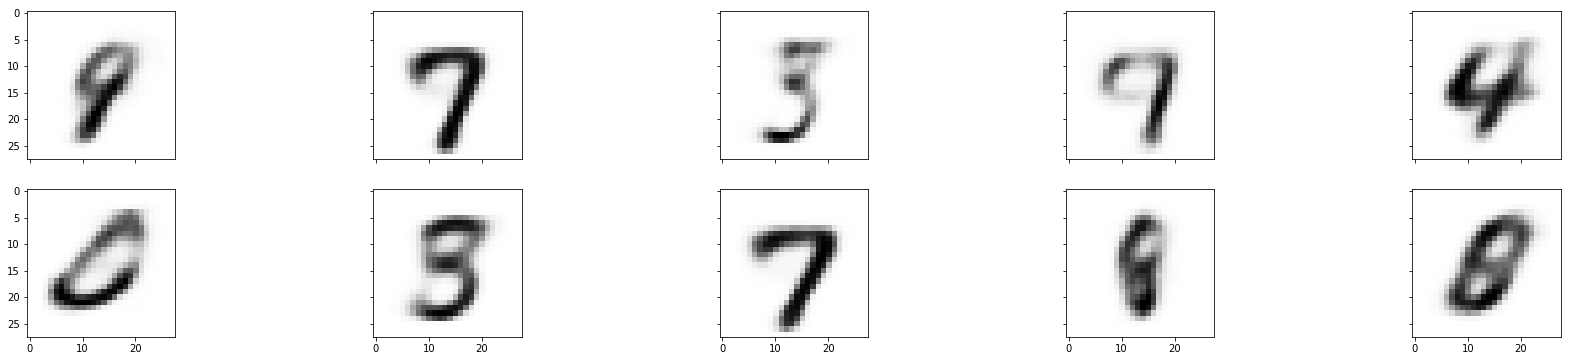

In [130]:
num_samples = 10

params = vae_module.get_params()[0]
# We group the outputs of phantasize to be able to process them as a single symbol
dream_digits = mx.sym.Group(vae.phantasize(num_samples))
# construct an executor by binding the parameters to the learned values
dream_exec = dream_digits.bind(ctx=ctx, args=params)

# run the computation
digits, latent_values = dream_exec.forward()

# transform output into numpy arrays
digits = digits.asnumpy()
latent_values = latent_values.asnumpy()
rows = int(num_samples / 5)

plot, axes = plt.subplots(rows, 5,  sharex='col', sharey='row', figsize=(30,6))
sample=0
for row in range(rows):
    for col in range(5):
        axes[row][col].imshow(np.reshape(digits[sample,:],(width,height)), cmap=cm.Greys)
        sample += 1
plt.show()

Notice that the above samples were obtained by sampling from the standard normal prior. We can also check the reconstruction abilities of the VAE. To do this we sample a random number from the test set and generate 10 reconstructions of it.

In [65]:
file_name = join(data_dir, "binary_mnist.{}".format(TEST_SET))
logging.info("Reading {} into memory".format(file_name))
test_set = np.genfromtxt(file_name)

15:08:23 [INFO]: Reading ./binary_mnist/binary_mnist.test into memory


Here is what the sampled number looks like. (Rerun if you want a different number.)

17:28:41 [DEBUG]: update_title_pos
17:28:41 [DEBUG]: update_title_pos
17:28:41 [DEBUG]: update_title_pos
17:28:41 [DEBUG]: update_title_pos


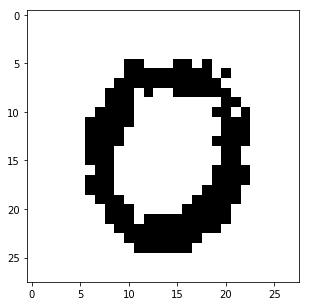

In [131]:
random_idx = np.random.randint(test_set.shape[0])
random_picture = test_set[random_idx, :]
plot, canvas = plt.subplots(1, figsize=(5,5))
canvas.imshow(np.reshape(random_picture,(width,height)), cmap=cm.Greys)
plt.show()

And now we are going to see how the VAE reconstructs it.

17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:49 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:50 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: update_title_pos
17:28:51 [DEBUG]: up

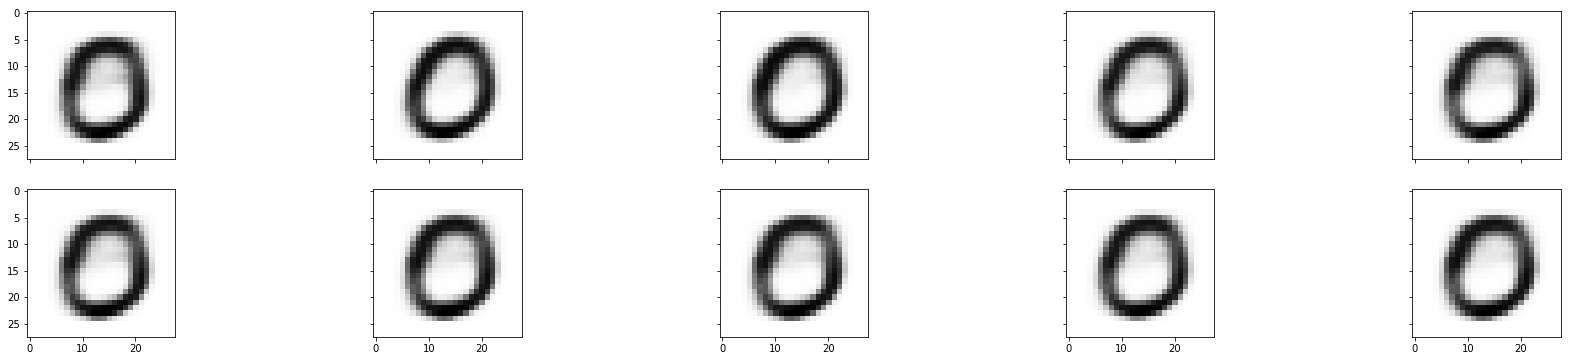

In [132]:
num_samples = 10

params = vae_module.get_params()[0]
# We group the outputs of generate_reconstructions to be able to process them as a single symbol
reconstructions = mx.sym.Group(vae.generate_reconstructions(mx.sym.Variable("random_digit"), num_samples))
# construct an executor by binding the parameters to the learned values
params["random_digit"] = mx.nd.array(random_picture.reshape((1,height*width)))
reconstruction_exec = reconstructions.bind(ctx=ctx, args=params)

# run the computation
digits, latent_values = reconstruction_exec.forward()

# transform output into numpy arrays
digits = digits.asnumpy()
latent_values = latent_values.asnumpy()

# plot the reconstructed digits
rows = int(num_samples / 5)
plot, axes = plt.subplots(rows, 5,  sharex='col', sharey='row', figsize=(30,6))
sample=0
for row in range(rows):
    for col in range(5):
        axes[row][col].imshow(np.reshape(digits[sample,:],(width,height)), cmap=cm.Greys)
        sample += 1
plt.show()

# Congrats!

You have completed your first VAE tutorial. From here on you can modify this code to play with your own VAE ideas. Want to you use different data? Or vary the neural net structure for the generator or inference networks? Or use a different likelihood model? The world of probablistic modeling is yours to explore.